In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
from util import add_angles, angle_between, angled_vector

In [2]:
def get_rotation_matrix(angle):
    c = np.cos(angle)
    s = np.sin(angle)
    R = np.array([c, -s, s, c]).reshape(2,2)
    return R

In [3]:
R = get_rotation_matrix(np.deg2rad(270))
R @ np.array([1,0])

array([ -1.83697020e-16,  -1.00000000e+00])

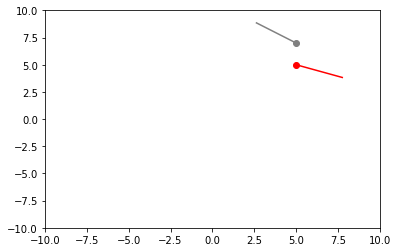

In [4]:
def plot_grid(p1, p2, traj1, traj2):
    fig, ax = plt.subplots()
    ax.scatter(p1[0], p1[1], c='r')
    ax.scatter(p2[0], p2[1], c='gray')

    ax.plot([p1[0], p1[0] + traj1[0]], [p1[1], p1[1] + traj1[1]], c='r')
    ax.plot([p2[0], p2[0] + traj2[0]], [p2[1], p2[1] + traj2[1]], c='gray')

    ax.set_xbound(-10, 10)
    ax.set_ybound(-10, 10)
    

pos1, pos2 = np.array([5,5]), np.array([5,7])
ang1, ang2 = np.deg2rad([-23, 142])
traj1, traj2 = angled_vector(ang1) * 3, angled_vector(ang2) * 3

plot_grid(pos1, pos2, traj1, traj2)

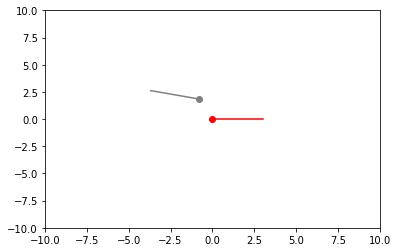

In [5]:
# RF
# 1. Rotate coord system.
R = get_rotation_matrix(-ang1)
pos1_rot = R @ pos1.reshape(2,1)
pos2_rot = R @ pos2.reshape(2,1)
traj1_rot = R @ traj1
traj2_rot = R @ traj2
# 2. Set p1 at center (0,0) and adjust other
pos2_rot -= pos1_rot
pos1_rot = np.array([0.0, 0.0])
ang1_rot = 0.0
ang2_rot = ang2 - ang1
# 3. Plot
plot_grid(pos1_rot, pos2_rot, traj1_rot, traj2_rot)

In [6]:
df_kicks_tr = pd.read_csv('../../data/processed/kicks_guy_train.csv')

In [7]:
from itertools import product
# Consider only a small subsample of data here.
df = df_kicks_tr.loc[df_kicks_tr['dt'] == 0, :]
wall_dist_col = [f'wall_distance{i}_f{id}' for i, id in product(range(0,4), range(0,2))]
min_wall_dist = df[wall_dist_col].min(axis=1)

df = df.loc[min_wall_dist > 7,:]
df = df[['heading_change', 'x_f0', 'y_f0', 'x_f1', 'y_f1', 'angle_f0', 'angle_f1']]

In [8]:
df.describe()

,heading_change,x_f0,y_f0,x_f1,y_f1,angle_f0,angle_f1
count,3285.000000,3285.000000,3285.000000,3285.000000,3285.000000,3285.000000,3285.000000
mean,-0.006504,14.835999,15.003341,14.847285,15.024099,0.258115,0.232886
std,0.621855,4.397897,4.253938,4.345620,4.245736,1.795103,1.797778
min,-2.893839,7.079950,7.404922,7.093593,7.420486,-3.139636,-3.141003
25%,-0.307478,11.097766,11.240831,11.206041,11.306380,-1.307826,-1.352690
50%,-0.016957,14.545566,15.025606,14.583979,15.009754,0.636821,0.593866
75%,0.309943,18.652061,18.595314,18.579060,18.542810,1.723791,1.708133
max,3.043295,22.925577,22.878628,22.919561,22.894960,3.137733,3.140597


In [9]:
df.head()

,heading_change,x_f0,y_f0,x_f1,y_f1,angle_f0,angle_f1
6,-0.030674,13.575349,21.004326,15.942150,19.501982,-2.321174,-2.676828
9,1.339604,12.241835,19.894104,15.410355,19.254524,-2.351849,-2.754446
12,-0.404984,13.242593,17.853865,15.396877,18.619726,-1.012245,-1.608275
15,-0.361000,13.424296,16.481699,15.373794,17.118202,-1.417229,-1.183269
18,0.837006,13.018435,15.021468,15.502907,15.195181,-1.778229,-1.496839


In [10]:
# Compute relative coords/angles
def transform_row(row):
    rotation_angle = row['angle_f0']
    rotation_matrix = get_rotation_matrix(-rotation_angle)
    
    pos_f0 = np.array([row['x_f0'], row['y_f0']])
    pos_f1 = np.array([row['x_f1'], row['y_f1']])
    
    # Rotate both fish s.t. fish 0 has angle 0
    pos_f0 = (rotation_matrix @ pos_f0.reshape(2,1))
    pos_f1 = (rotation_matrix @ pos_f1.reshape(2,1))
    
    # Put fish zero at (0,0) in coord system
    pos_f1 = (pos_f1 - pos_f0).reshape(2)
    pos_f0 = np.array([0,0])

    angle_f1 = row['angle_f1'] - rotation_angle
    
    row = pd.Series(data=[row['heading_change'], pos_f1[0], pos_f1[1], angle_f1],
                    index=['heading_change', 'x_f1', 'y_f1', 'angle_f1'])
    return row

df = df.apply(transform_row, axis=1)

In [11]:
def get_bins(df, num_bins=5):
    # Build symmetric receptive field.
    rf_size = max(df['x_f1'].abs().max(), df['y_f1'].abs().max())
    
    # RF has size rf_size x rf_size, each direction divided by num_bins
    # Should be of form 2n-1 (symmetric in pos/neg. direction, centered at (0,0))
    assert(((num_bins-1) % 2) == 0)
    
    b = np.linspace(rf_size, 0, num=num_bins//2, endpoint=False)
    #b = np.array([rf_size/(i+1) for i in range(num_bins//2)])
    bins = np.hstack((-b,[0], b[::-1]))
    
    return bins
get_bins(df,11)

array([-7.97543544, -6.38034835, -4.78526127, -3.19017418, -1.59508709,
        0.        ,  1.59508709,  3.19017418,  4.78526127,  6.38034835,
        7.97543544])

In [12]:
bins = get_bins(df, 5)
def get_bin(df, bins):
    bin_x = np.digitize(df['x_f1'], bins=bins) - 1
    bin_y = np.digitize(df['y_f1'], bins=bins) - 1
    return (bin_x*len(bins)) + bin_y

df['bins'] = pd.Series(get_bin(df, bins), index=df.index)
df.head()

,heading_change,x_f1,y_f1,angle_f1,bins
6,-0.030674,-0.515097,2.755624,-0.355654,7
9,1.339604,-1.776512,2.700479,-0.402597,7
12,-0.404984,0.492213,2.232759,-0.596031,12
15,-0.361000,-0.330809,2.023917,0.233960,7
18,0.837006,-0.681662,2.395437,0.281390,7


In [13]:
# Now we need to one-hot enccode our data.
# We need one column per variable and bin

# Indicator for position
position_one_hot = pd.get_dummies(df['bins'])
# Mean of angle for bin
angle_one_hot = pd.get_dummies(df['bins']).values * df['angle_f1'][:, None]

X_np = np.concatenate((position_one_hot, angle_one_hot), axis=1)
#X = angle_one_hot
y_np = df['heading_change'].values

In [14]:
import torch
from torch.autograd import Variable
from torch.utils import data
from torch import nn
from torch import optim

X = torch.from_numpy(X_np).float()
y = torch.from_numpy(y_np).float()
train = data.TensorDataset(data_tensor=X, target_tensor=y)
train_data = data.DataLoader(train, batch_size=512, pin_memory=True)
type(X), type(y)

(torch.FloatTensor, torch.FloatTensor)

In [15]:
class LinearRF(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        n_hidden=1
        self.linear = nn.Linear(in_features=n_features, out_features=1, bias=True)     
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.fill_(0.0)

        
    def forward(self, x):
        return self.linear(x)
    
class MlpRF(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        n_hidden=256
        linear_out = nn.Linear(in_features=n_hidden, out_features=1, bias=True)  
        self.layers = nn.Sequential(*[
            nn.Linear(in_features=n_features, out_features=n_hidden),
            nn.Dropout(p=0.1),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=n_hidden, out_features=n_hidden),
            nn.Dropout(p=0.1),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=n_hidden, out_features=n_hidden),
            nn.Dropout(p=0.1),
            nn.ReLU(inplace=True),
            linear_out])
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.fill_(0.0)

        
    def forward(self, x):
        return self.layers(x)    
    
model = LinearRF(n_features=X.shape[1]).cuda()
#model = MlpRF(n_features=X.shape[1]).cuda()
#optimizer = optim.SGD(model.parameters(), weight_decay=10e-4, momentum=0.9, lr=1e-3)
optimizer = optim.Adam(model.parameters(), weight_decay=0, lr=1e-3)

In [16]:
num_epochs = 1000
for epoch in range(num_epochs):
    cur_loss = 0.0
    for batch in train_data:
        x_batch, y_batch = [Variable(b.float().cuda()) for b in batch]

        optimizer.zero_grad()
        
        y_hat = model(x_batch).squeeze()
        #print(y_batch.shape, y_hat.shape)
        loss = torch.sum((y_hat - y_batch)**2)
        loss.backward()
        optimizer.step()
        
        cur_loss += loss.data[0]

    if (epoch % 100) == 0:
        print(cur_loss/len(X))

0.3856860075185651
0.3404868742828137
0.3376050951999798
0.3367527687386291
0.3365610932650631
0.3365363749557797
0.33653491991295664
0.3365349605566109
0.3365350139739851
0.336535061585123


In [17]:
y_hat = model(Variable(X.unsqueeze(1).cuda())).squeeze().cpu().data.numpy()
np.linalg.norm(y_hat - df['heading_change']), np.linalg.norm(df['heading_change'].mean() - df['heading_change'])

(33.246865174936168, 35.636145175997669)

In [18]:
err = (model(x_batch) - y_batch).cpu().data.numpy()

In [19]:
np.abs(np.rad2deg(err)).mean()

19.052078

In [20]:
np.abs(np.rad2deg(torch.mean(y_batch).cpu().data.numpy()))

array([ 4.51676893], dtype=float32)

In [21]:
import sklearn.linear_model as lm
linear = lm.ElasticNetCV(l1_ratio=0.95)
linear = linear.fit(X_np,y)

In [22]:
linear.coef_, linear.intercept_

(array([ 0.        , -0.        ,  0.        , -0.44910849, -0.24629289,
         0.16763008,  0.2006495 ,  0.        , -0.03136365, -0.1433585 ,
         0.10101831,  0.14559537,  0.        , -0.        ,  0.        ,
        -0.        ,  0.        ,  0.25886968,  0.        ,  0.01151833,
        -0.01808162,  0.        ,  0.        ,  0.        , -0.00191581,
         0.        ,  0.        , -0.        , -0.        ,  0.        ]),
 0.031076939910638809)

In [23]:
linear.score(X_np, y)

0.1081426703171343

In [24]:
from sklearn import metrics
enet_r2 = metrics.r2_score(y_true=y_np, y_pred=linear.predict(X_np), )

nn_yhat = model(Variable(X.cuda())).cpu().data.numpy()
nn_r2 = metrics.r2_score(y_true=y_np, y_pred=nn_yhat)

mean_yhat = np.ones_like(y_np) * y_np.mean()
mean_r2 = metrics.r2_score(y_true=y_np, y_pred=mean_yhat)

enet_r2, nn_r2, mean_r2

(0.10814267101761221, 0.12959782933035013, 0.0)

In [56]:
linear.fit(df.drop('heading_change', axis=1), y_np)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.95, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [57]:
linear.coef_, linear.intercept_

(array([ 0.01192062,  0.11572147,  0.00379588, -0.00934351]),
 0.085493697210711303)

In [58]:
linear.score(df.drop('heading_change', axis=1), y_np)

0.14325640963509834